# Compare predictions

In [1]:
library(tidyverse)

── Attaching packages ───────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
# PixelSpacing is 0.425 in both directions, except for A29,A30 (0.5) and A32 (0.40625)
ml_per_pix = (800/256)*(800/256)*0.425*0.425*6/1000
ml_per_pix

[1] 0.0105835

In [3]:
theme_set(theme_minimal())
options(repr.plot.width = 14)

In [4]:
sets <- read_tsv("../inputs/training/cmr-cine-sscrofa.sets.tsv") %>% rename(Id=id)

Rows: 44 Columns: 2
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): id, set

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
prepare_confusion_table <- function(data){
   return(data %>% mutate(
            Id=str_replace(image,"_slice.*",""),
            slice=str_replace(image,".*_slice(\\d+)_frame.*","\\1") %>% as.numeric,
            frame=str_replace(image,".*_frame(\\d+)","\\1") %>% as.numeric,
            #total=256*256,
            bg_all=bg_bg+bg_lv+bg_my,
            all_bg=bg_bg+lv_bg+my_bg,
            lv_all=lv_bg+lv_lv+lv_my,
            all_lv=bg_lv+lv_lv+my_lv,
            dice_lv=if_else(lv_all+all_lv==0, 1, 2*lv_lv/(lv_all+all_lv)),
            my_all=my_bg+my_lv+my_my,
            all_my=bg_my+lv_my+my_my,
            dice_my=if_else(my_all+all_my==0, 1, 2*my_my/(my_all+all_my))
        ) %>%
        #select(-image) %>%
        left_join(sets, by="Id")
    ) 
}

In [6]:
conf_matrix <- function(data, mask_bg_bg=FALSE, normalize_row=TRUE){
    if(normalize_row){
        data <- data %>% mutate(
            bg_bg = bg_bg/bg_all,
            bg_lv = bg_lv/bg_all,
            bg_my = bg_my/bg_all,
            lv_bg = lv_bg/lv_all,
            lv_lv = lv_lv/lv_all,
            lv_my = lv_my/lv_all,
            my_bg = my_bg/my_all,
            my_lv = my_lv/my_all,
            my_my = my_my/my_all
        )
    }
    return(data %>% summarize(
            bg_bg=if_else(mask_bg_bg,as.numeric(NA),mean(bg_bg,na.omit=T)),
            bg_lv=mean(bg_lv,na.rm=T),
            bg_my=mean(bg_my,na.rm=T),
            lv_bg=mean(lv_bg,na.rm=T),
            lv_lv=mean(lv_lv,na.rm=T),
            lv_my=mean(lv_my,na.rm=T),
            my_bg=mean(my_bg,na.rm=T),
            my_lv=mean(my_lv,na.rm=T),
            my_my=mean(my_my,na.rm=T)
        ) %>%
            gather("combi","count",contains("_")) %>%
            separate(combi,into=c("a","b"),sep="_")
    )
}

In [7]:
obs0_rep0_model <- read_tsv("../outputs/prediction/comparison/dice_70_50-obs0_rep0-confusion.tsv") %>% prepare_confusion_table

Rows: 2363 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): image, methodA, methodB
dbl (9): bg_bg, bg_lv, bg_my, lv_bg, lv_lv, lv_my, my_bg, my_lv, my_my

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`summarise()` has grouped output by 'Id'. You can override using the `.groups` argument.


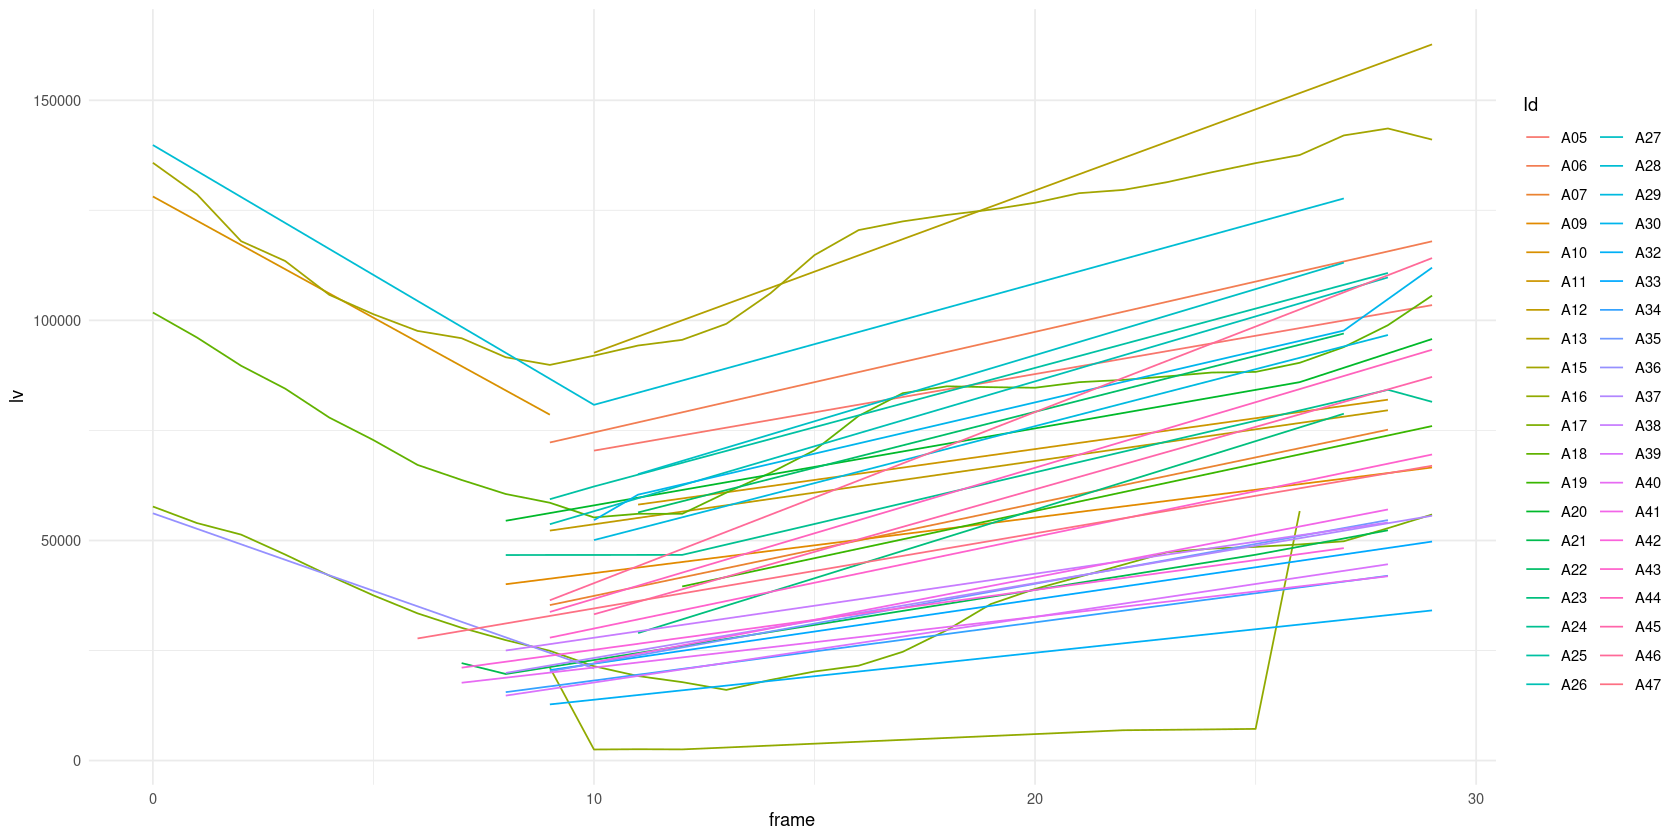

In [8]:
obs0_rep0_model %>%
    group_by(Id,frame) %>%
    summarize(lv=sum(all_lv)) %>%
    ungroup() %>%
    ggplot(aes(x=frame,y=lv,color=Id)) + geom_line()

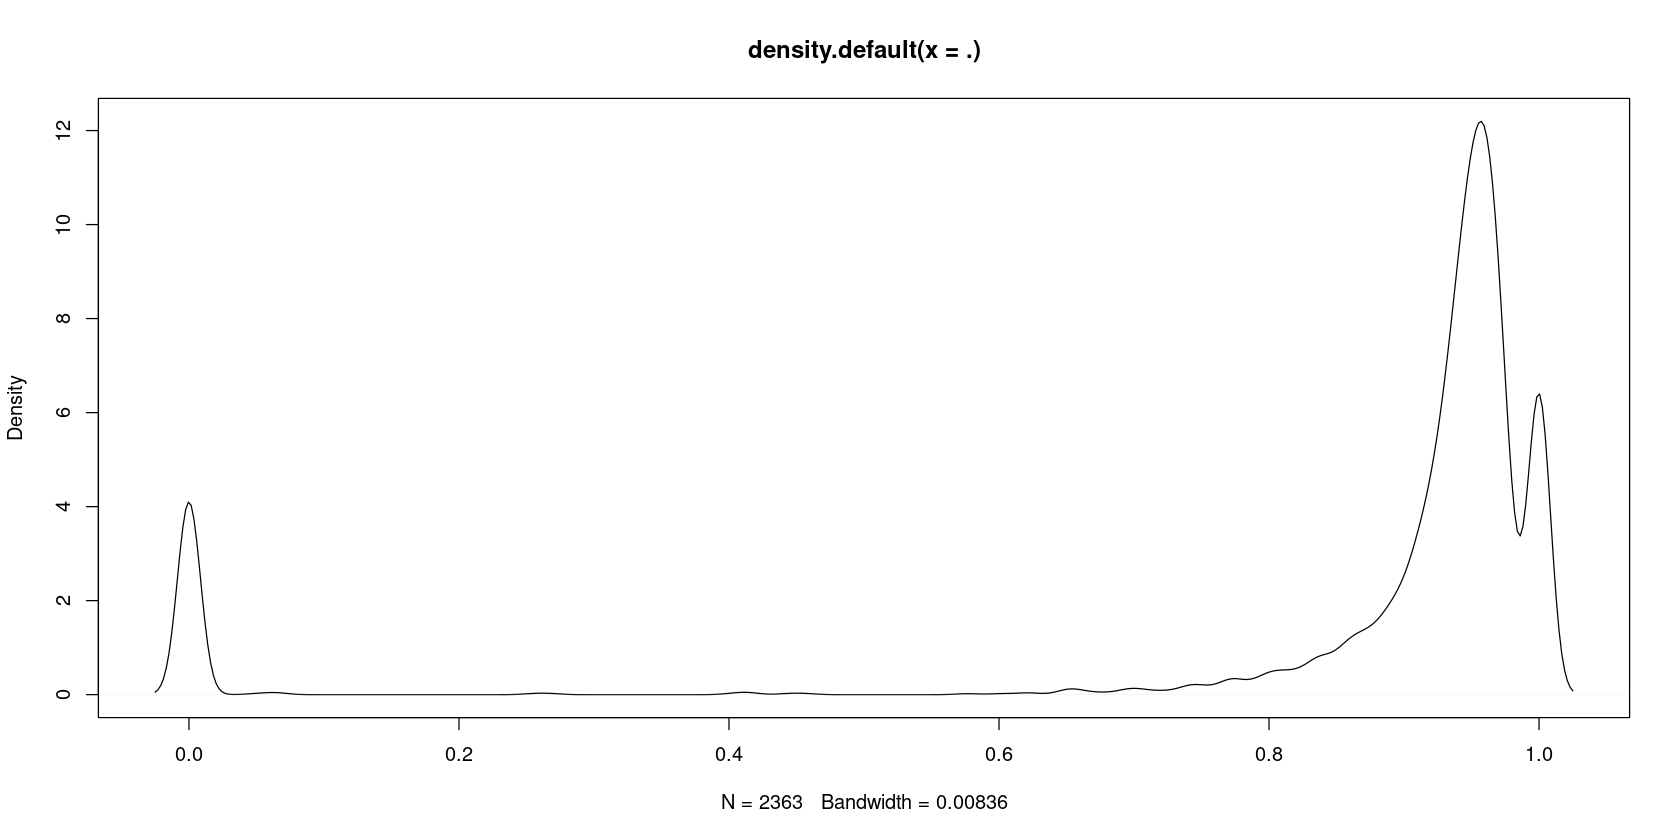

In [9]:
obs0_rep0_model %>% pull(dice_lv) %>% density %>% plot

In [10]:
obs0_rep0_model %>% select(image, methodA, methodB, lv=dice_lv, my=dice_my) %>% write_tsv("../outputs/prediction/comparison/dice_70_50-obs0_rep0-dice.tsv")

In [11]:
intraobs <- read_tsv("../outputs/prediction/comparison/obs0_rep0-obs0_rep1-confusion.tsv") %>% prepare_confusion_table

Rows: 1111 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): image, methodA, methodB
dbl (9): bg_bg, bg_lv, bg_my, lv_bg, lv_lv, lv_my, my_bg, my_lv, my_my

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
interobs <- read_tsv("../outputs/prediction/comparison/obs0_rep0-obs1_rep0-confusion.tsv") %>% prepare_confusion_table

Rows: 1137 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): image, methodA, methodB
dbl (9): bg_bg, bg_lv, bg_my, lv_bg, lv_lv, lv_my, my_bg, my_lv, my_my

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
interobs %>% select(image, methodA, methodB, lv=dice_lv, my=dice_my) %>% write_tsv("../outputs/prediction/comparison/obs0_rep0-obs1_rep0-dice.tsv")

In [14]:
obs1_model <- read_tsv("../outputs/prediction/comparison/obs1_rep0-dice_70_50-confusion.tsv") %>% prepare_confusion_table

Rows: 1151 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): image, methodA, methodB
dbl (9): bg_bg, bg_lv, bg_my, lv_bg, lv_lv, lv_my, my_bg, my_lv, my_my

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
data <- intraobs %>% bind_rows(obs0_rep0_model, interobs) %>%
    mutate(methodA = case_when(
        methodA == "obs0_rep0" ~ "observer 1",
        methodA == "obs0_rep1" ~ "repeat",
        methodA == "obs1_rep0" ~ "observer 2",
        methodA == "dice_70_50" ~ "DL",
    ), methodB = case_when(
        methodB == "obs0_rep0" ~ "observer 1",
        methodB == "obs0_rep1" ~ "repeat",
        methodB == "obs1_rep0" ~ "observer 2",
        methodB == "dice_70_50" ~ "DL",
    )) %>%
    identity

In [40]:
options(repr.plot.res = 300, repr.plot.width = 8, repr.plot.height = 5)

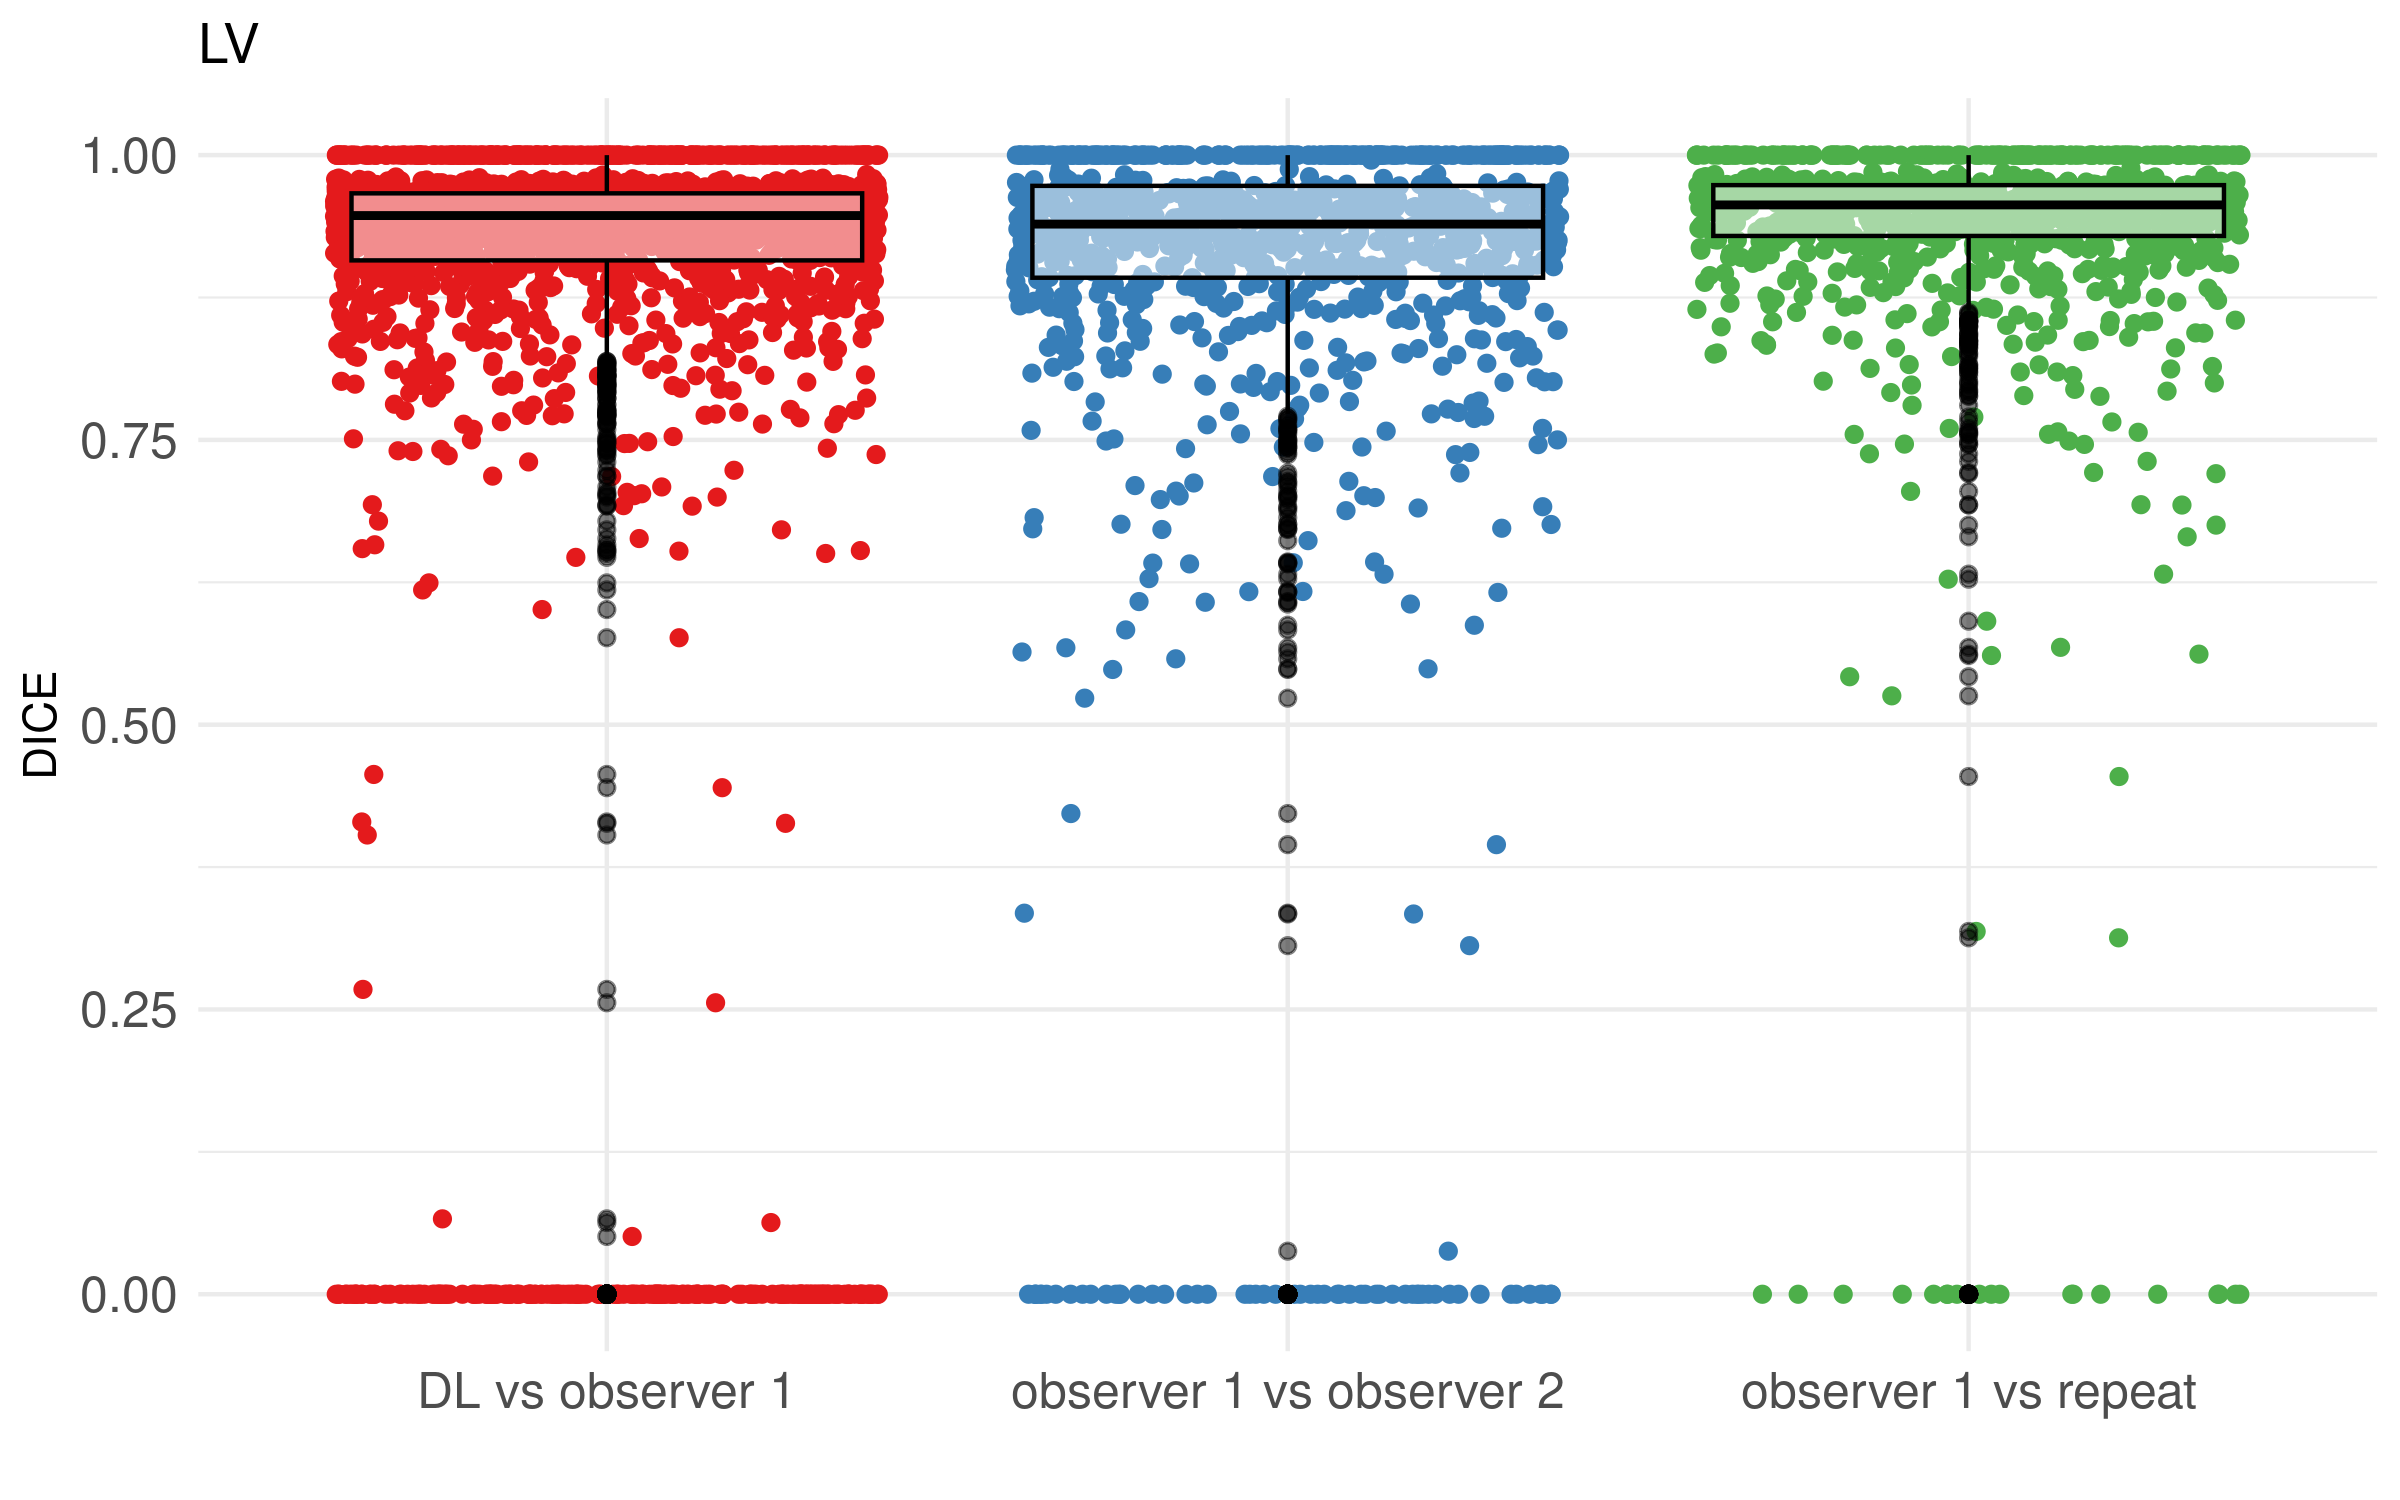

In [42]:
data %>%
    mutate(comparison = str_c(methodA,methodB,sep=" vs "), DICE=dice_lv) %>%
    ggplot(aes(x=comparison,y=DICE, color=comparison)) + geom_jitter() + ggtitle("LV") + geom_boxplot(color="black",alpha=.5) + scale_color_brewer(palette="Set1") +
    theme(legend.position = "none", axis.text = element_text(size = 12)) + xlab("")

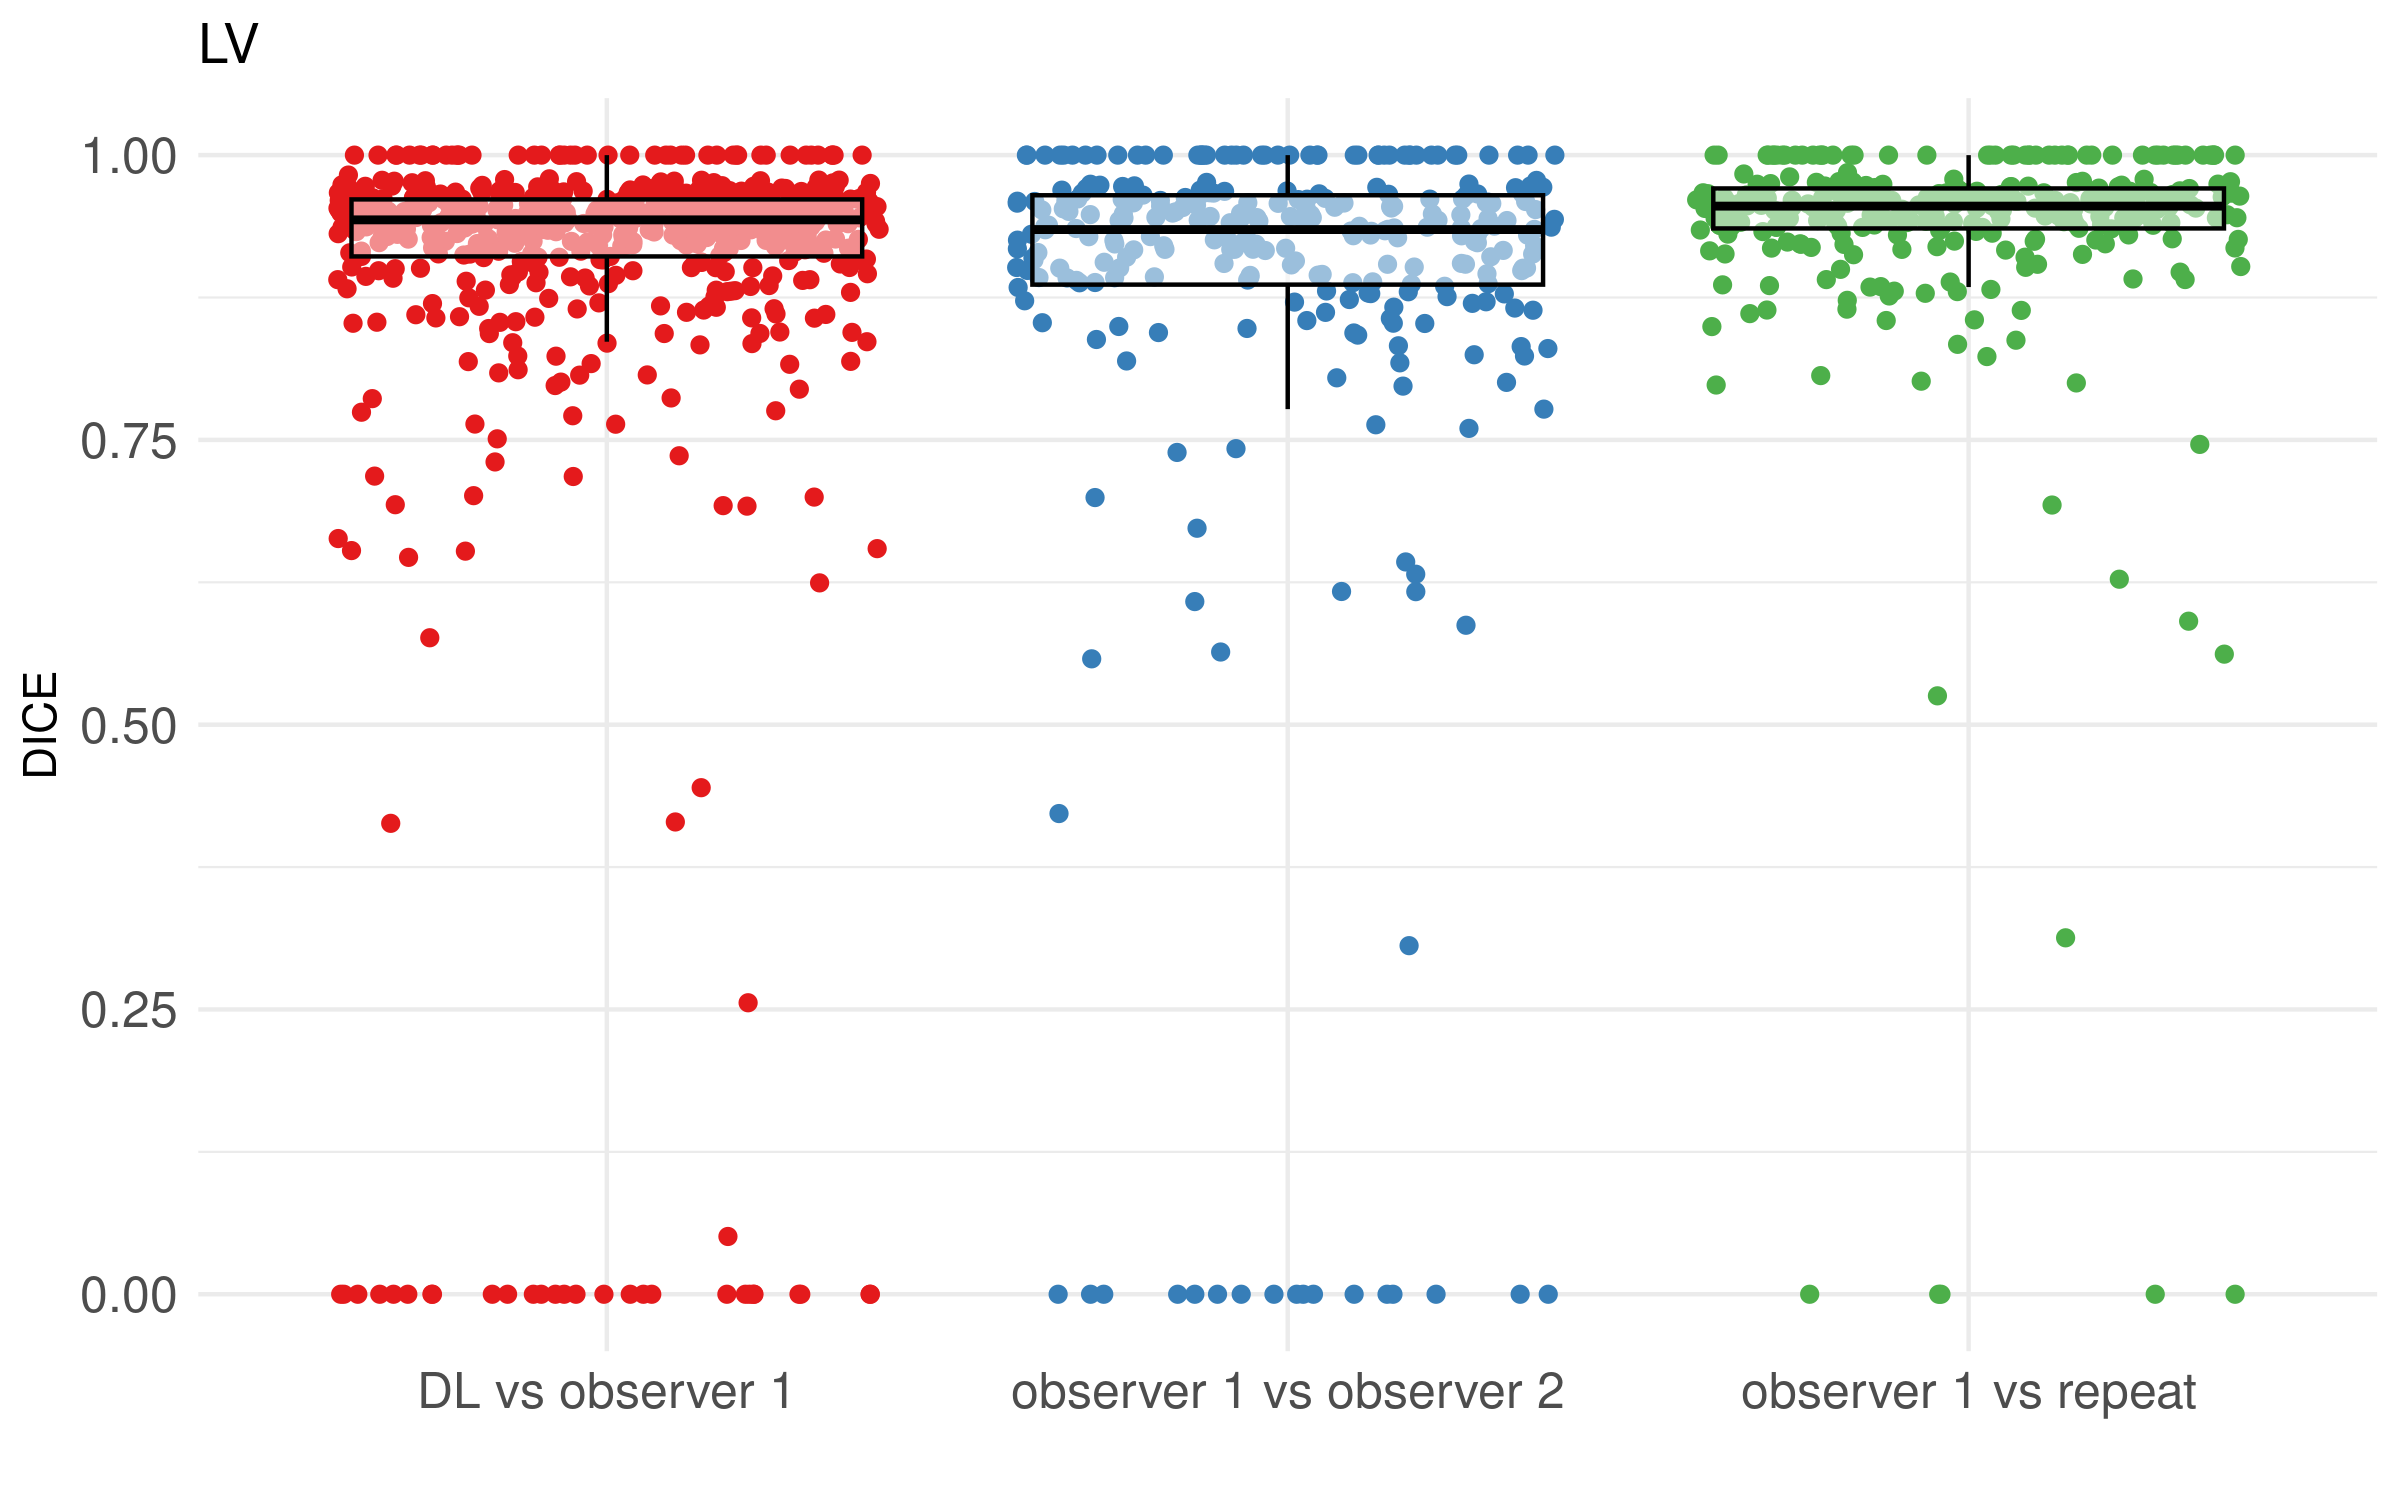

In [43]:
data %>%
    mutate(comparison = str_c(methodA,methodB,sep=" vs "), DICE=dice_lv) %>%
    filter(set == "test") %>%
    ggplot(aes(x=comparison,y=DICE, color=comparison)) + geom_jitter() + ggtitle("LV") + geom_boxplot(color="black",alpha=.5,outlier.shape=NA) + scale_color_brewer(palette="Set1") +
    theme(legend.position = "none", axis.text = element_text(size = 12)) + xlab("")

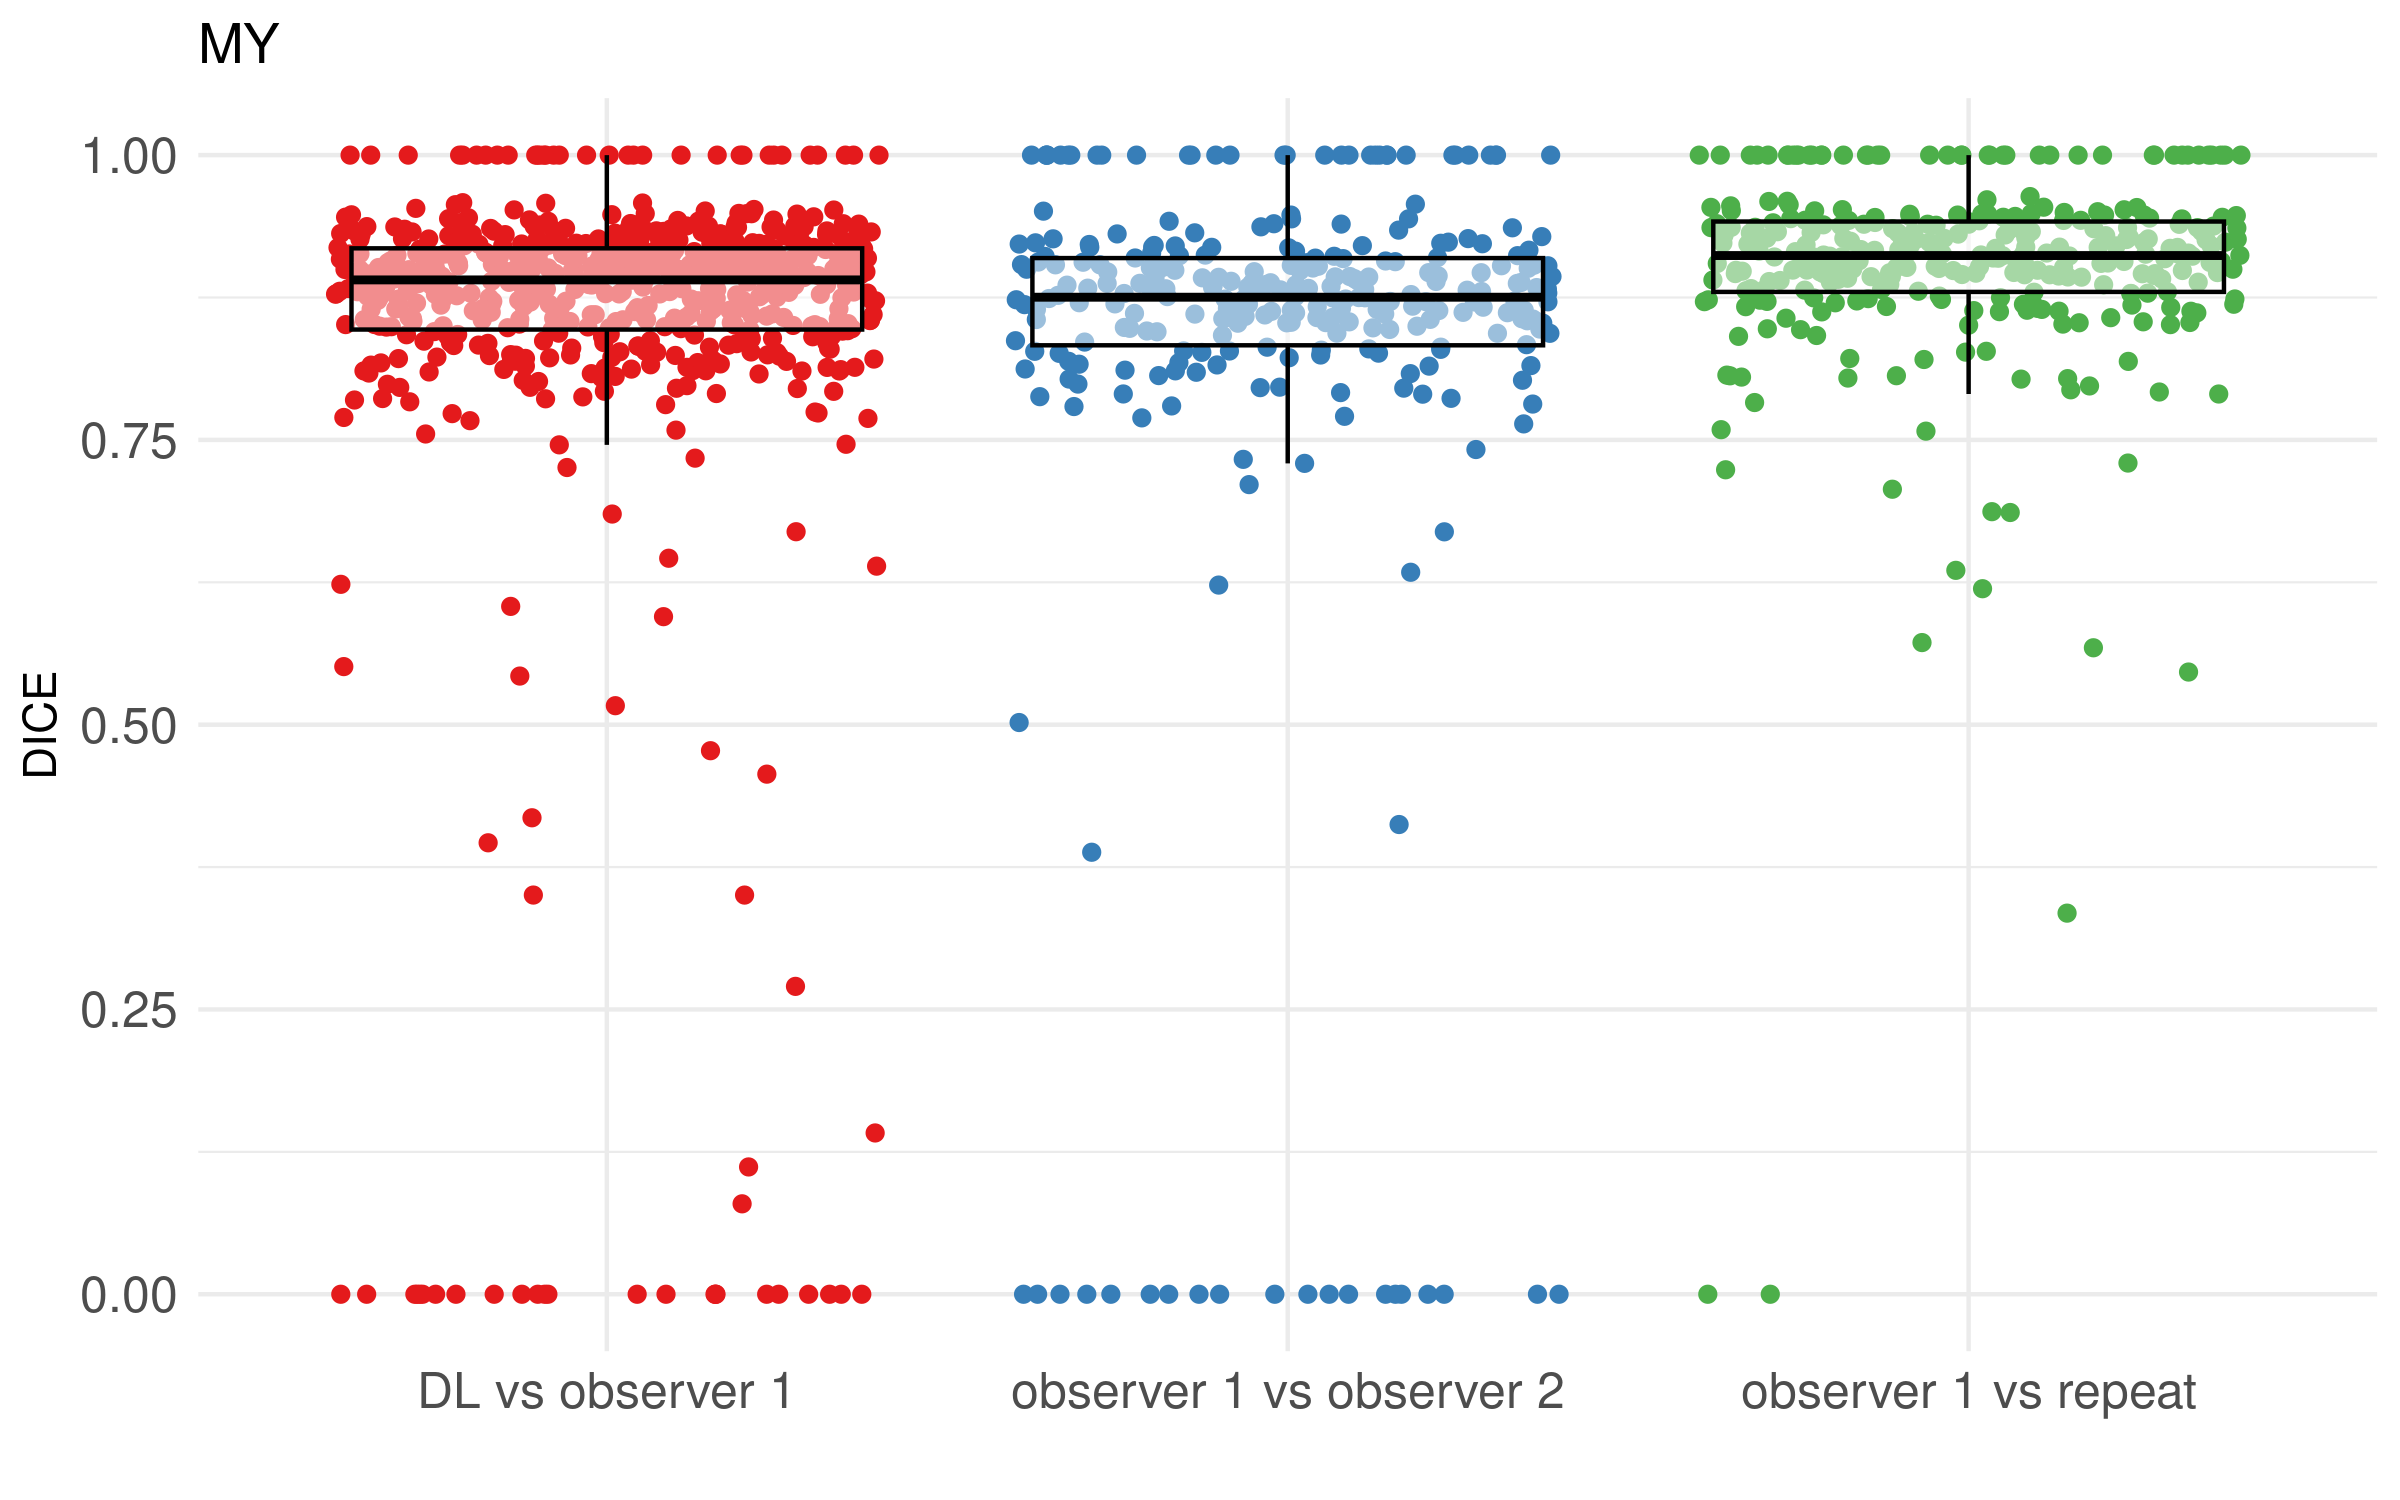

In [44]:
data %>%
    mutate(comparison = str_c(methodA,methodB,sep=" vs "), DICE=dice_my) %>%
    filter(set == "test") %>%
    ggplot(aes(x=comparison,y=DICE, color=comparison)) + geom_jitter() + ggtitle("MY") + geom_boxplot(color="black",alpha=.5,outlier.shape=NA) + scale_color_brewer(palette="Set1") +
    theme(legend.position = "none", axis.text = element_text(size = 12)) + xlab("")

In [45]:
library(cowplot)
library(grid)
library(gridExtra) 


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




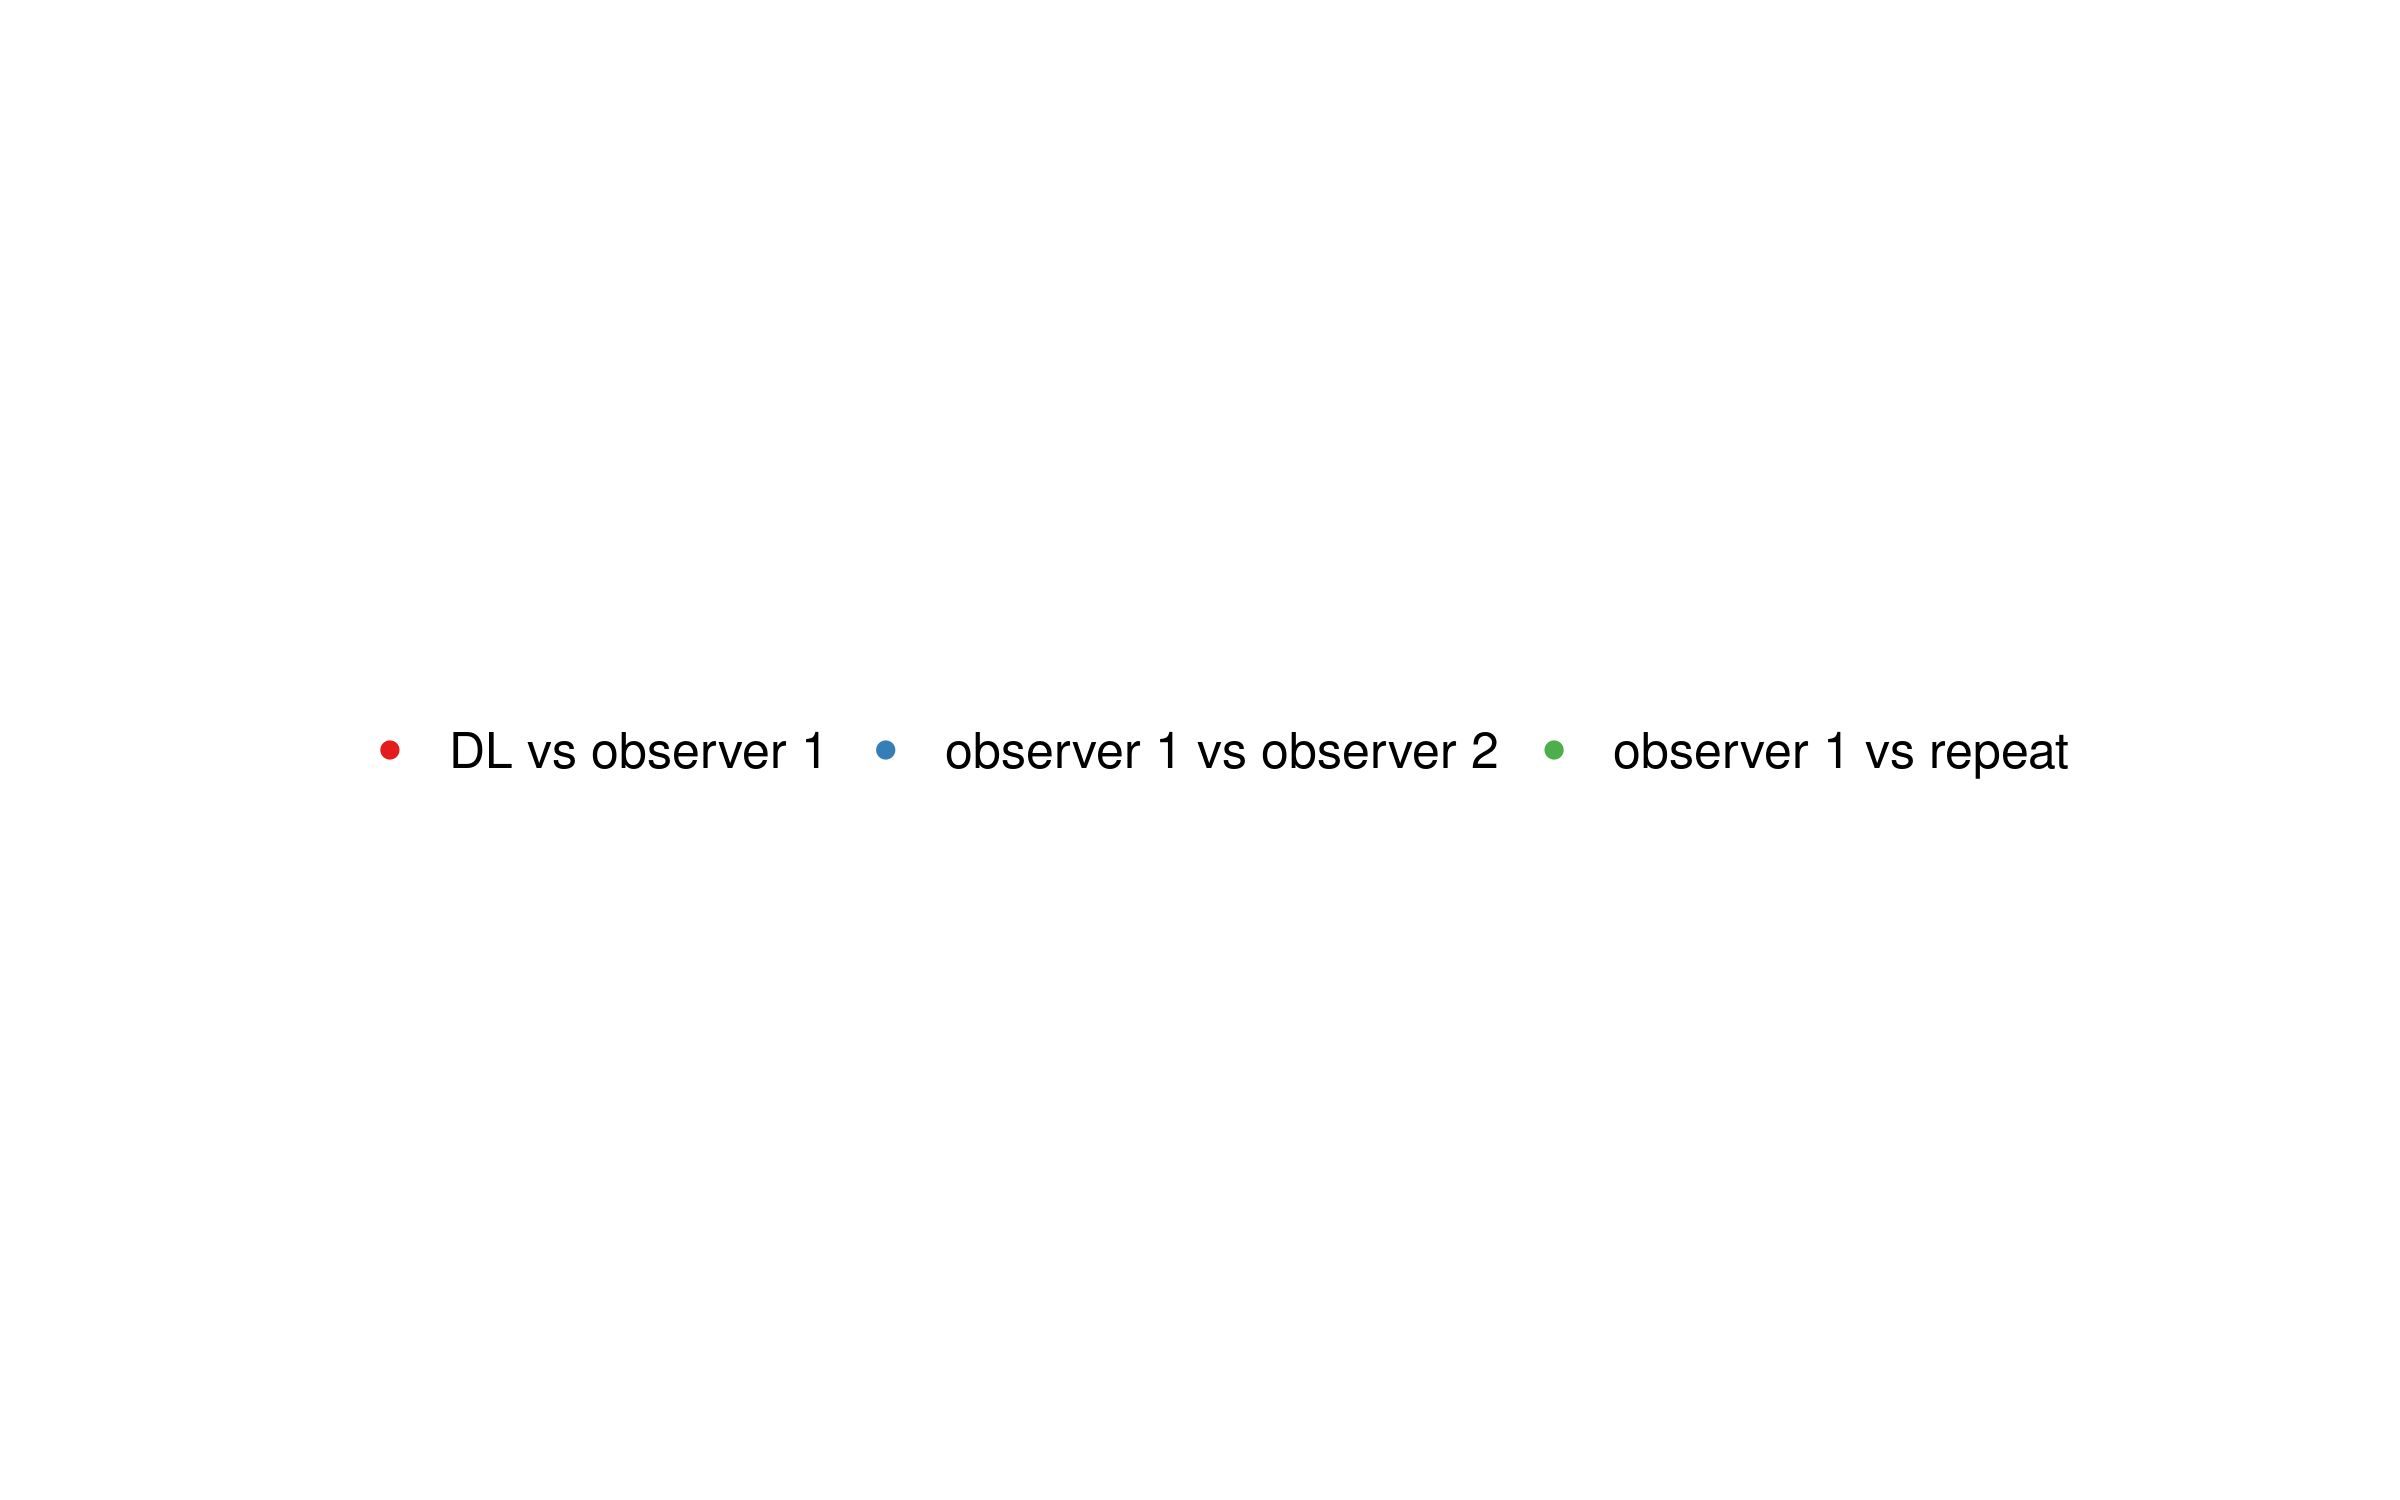

In [46]:
p <- data %>%
    mutate(comparison = str_c(methodA,methodB,sep=" vs "), DICE=dice_my) %>%
    filter(set == "test") %>%
    ggplot(aes(x=comparison,y=DICE, color=comparison)) + geom_jitter() + ggtitle("LV") + geom_boxplot(color="black",alpha=.5,outlier.shape=NA) + scale_color_brewer(palette="Set1") +
    theme(legend.position = "bottom", axis.text = element_text(size = 12), legend.title = element_blank(), legend.text = element_text(size=12)) + xlab("")

legend <- cowplot::get_legend(p)

grid.newpage()
grid.draw(legend)

In [47]:
data %>%
    filter(set=="test") %>%
    group_by(methodA, methodB) %>%
    summarize(across(c(dice_lv,dice_my),list(mean=mean,sd=sd,median=median,mad=mad)))

`summarise()` has grouped output by 'methodA'. You can override using the `.groups` argument.


methodA,methodB,dice_lv_mean,dice_lv_sd,dice_lv_median,dice_lv_mad,dice_my_mean,dice_my_sd,dice_my_median,dice_my_mad
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DL,observer 1,0.8843441,0.2061418,0.9431674,0.03030593,0.8422319,0.1921090,0.8904522,0.05094922
observer 1,observer 2,0.8621978,0.2343275,0.9346536,0.05559408,0.8167116,0.2364393,0.8752566,0.05315456
observer 1,repeat,0.9274542,0.1375102,0.9552145,0.02609125,0.8985398,0.1053075,0.9118432,0.04574014


## Hausdorff

In [48]:
get_hausdorff <- function(file){
    read_tsv(file) %>%
    mutate(
        Id=str_replace(image,"_slice.*",""),
        slice=str_replace(image,".*_slice(\\d+)_frame.*","\\1") %>% as.numeric,
        frame=str_replace(image,".*_frame(\\d+)","\\1") %>% as.numeric,
    ) %>%
    select(-image) %>%
    left_join(sets, by="Id")
}

In [49]:
haus_obs0_rep0_model <- get_hausdorff("../outputs/prediction/comparison/dice_70_50-obs0_rep0-hausdorff.tsv")
haus_obs1_rep0_model <- get_hausdorff("../outputs/prediction/comparison/obs1_rep0-dice_70_50-hausdorff.tsv")
haus_interobs <- get_hausdorff("../outputs/prediction/comparison/obs0_rep0-obs1_rep0-hausdorff.tsv")
haus_intraobs <- get_hausdorff("../outputs/prediction/comparison/obs0_rep0-obs0_rep1-hausdorff.tsv")

Rows: 2363 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): image, methodA, methodB
dbl (2): lv, my

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1151 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): image, methodA, methodB
dbl (2): lv, my

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1137 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): image, methodA, methodB
dbl (2): lv, my

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet thi

In [50]:
haus_data <- haus_intraobs %>% bind_rows(haus_obs0_rep0_model, haus_interobs) %>%
    mutate(methodA = case_when(
        methodA == "obs0_rep0" ~ "observer 1",
        methodA == "obs0_rep1" ~ "repeat",
        methodA == "obs1_rep0" ~ "observer 2",
        methodA == "dice_70_50" ~ "DL",
    ), methodB = case_when(
        methodB == "obs0_rep0" ~ "observer 1",
        methodB == "obs0_rep1" ~ "repeat",
        methodB == "obs1_rep0" ~ "observer 2",
        methodB == "dice_70_50" ~ "DL",
    )) %>%
    identity

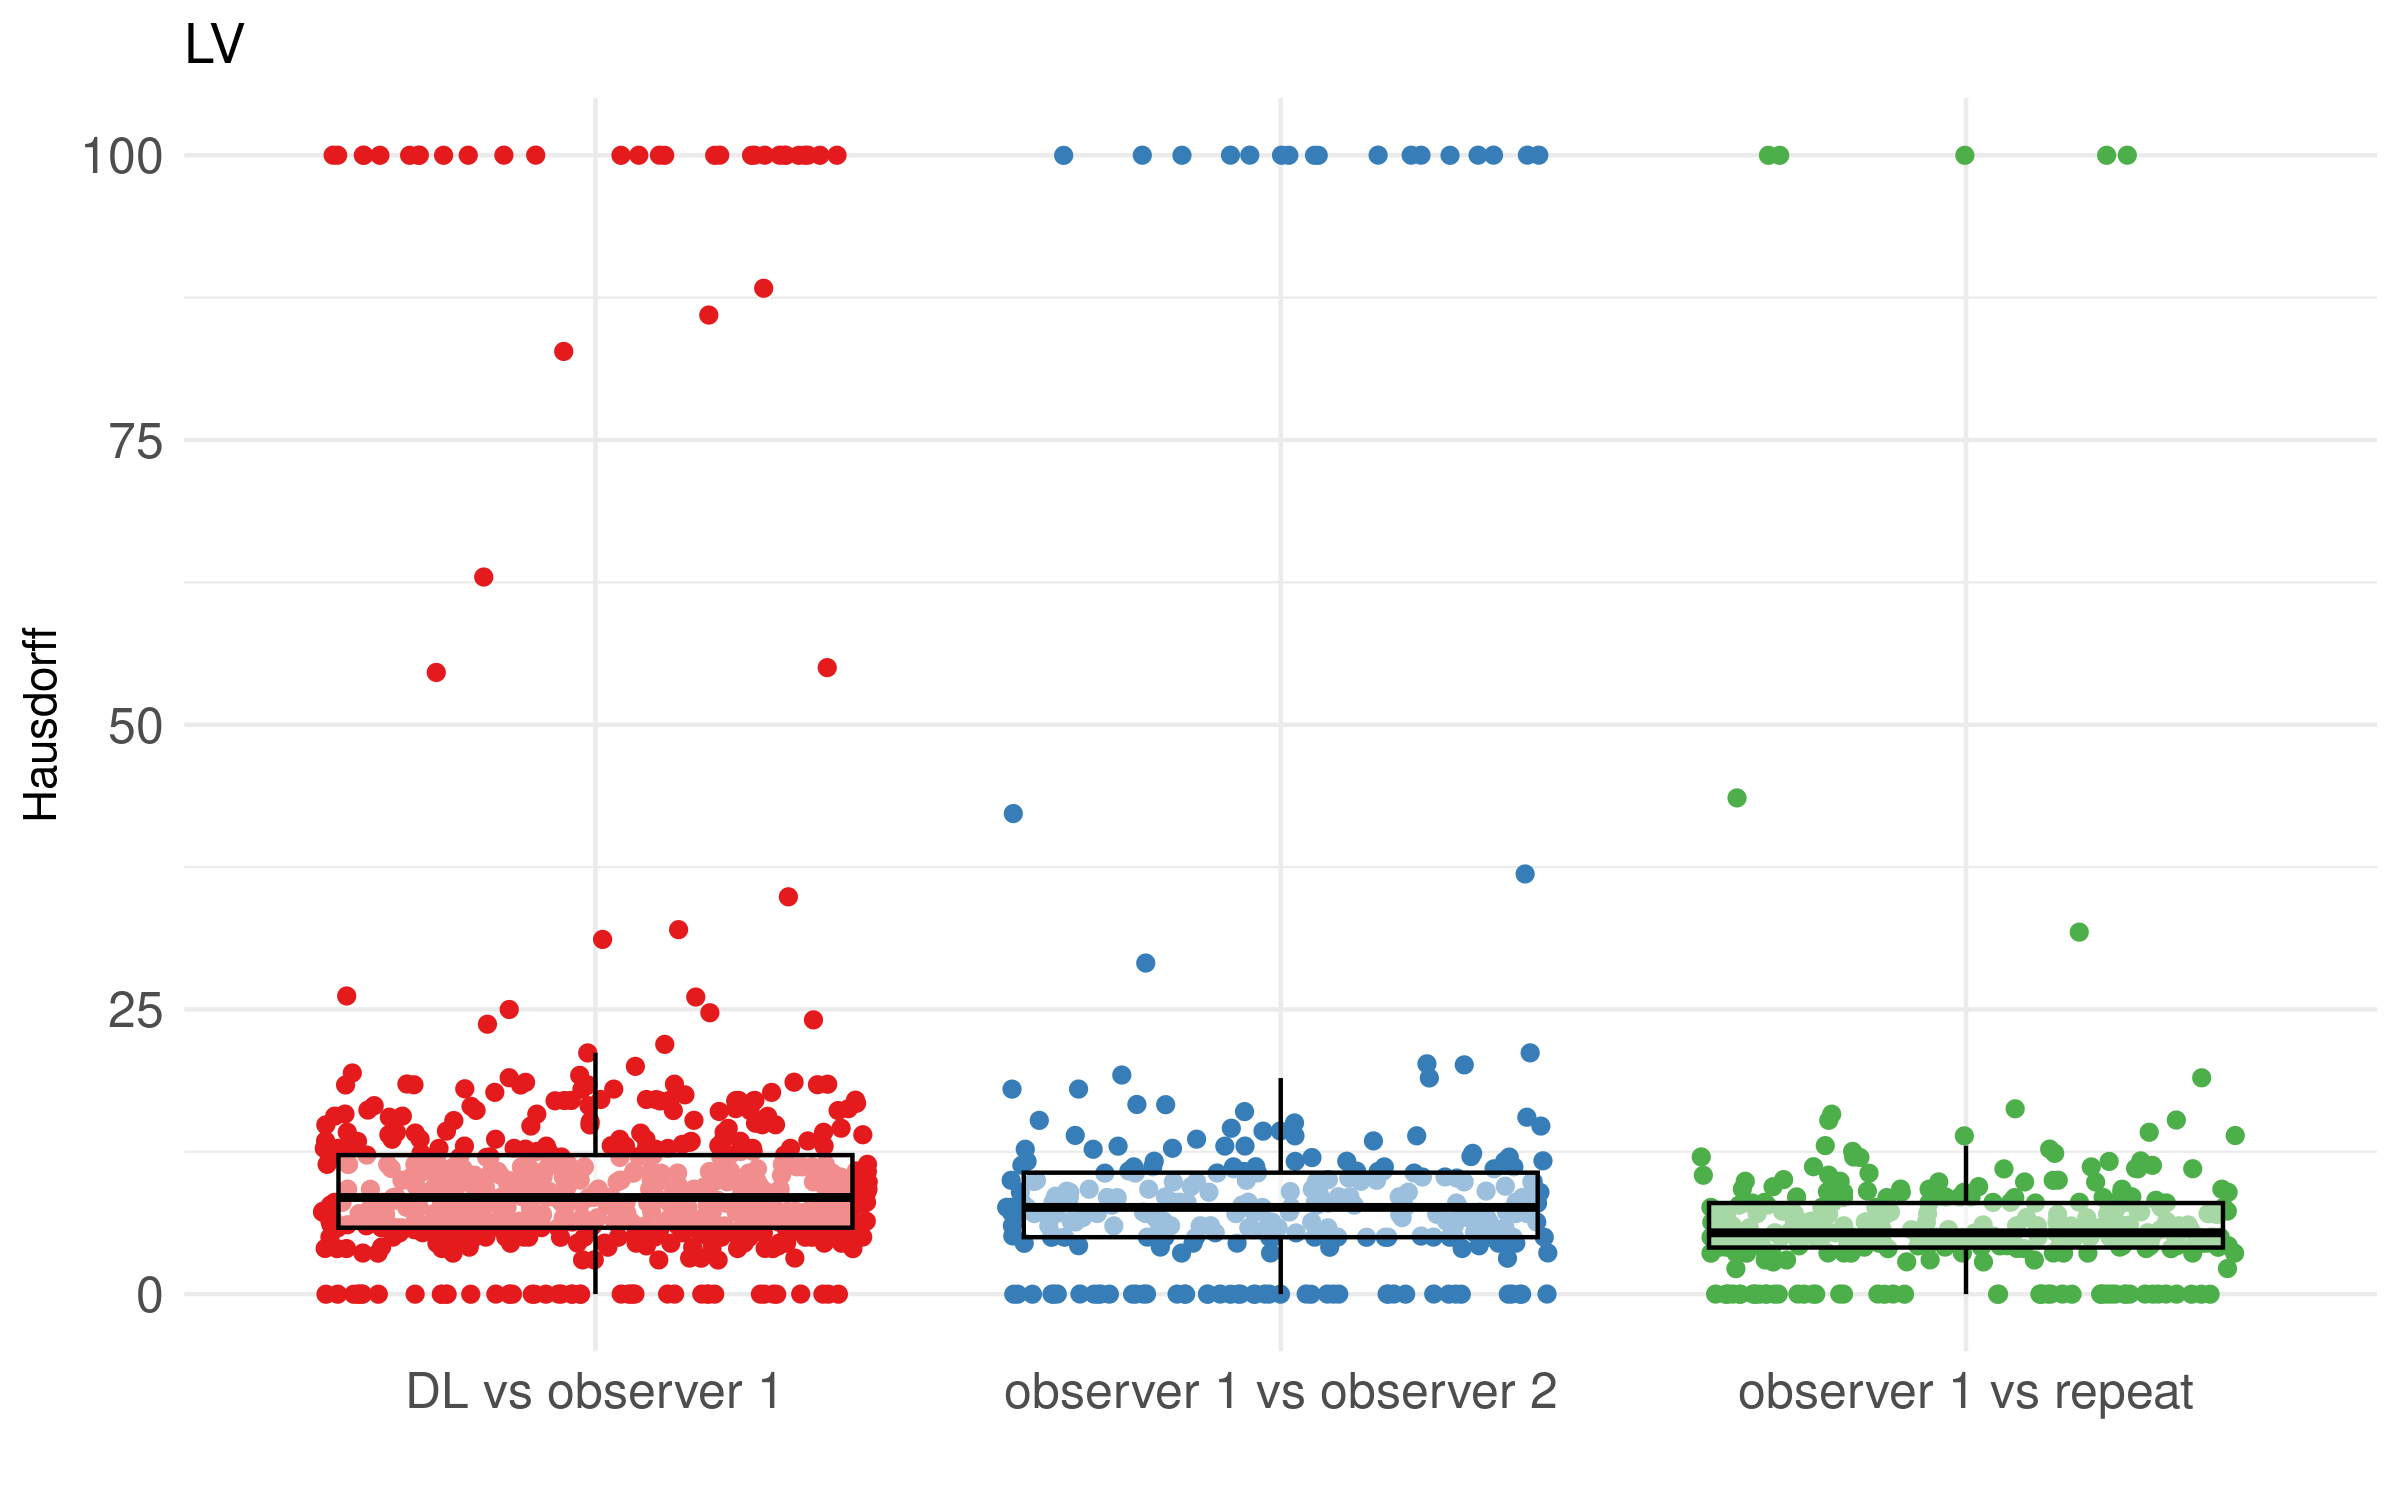

In [51]:
haus_data %>%
    mutate(comparison = str_c(methodA,methodB,sep=" vs "), Hausdorff=lv) %>%
    mutate(Hausdorff = if_else(lv<100,lv,100)) %>% # add inf values to the plot
    filter(set == "test") %>%
    ggplot(aes(x=comparison,y=Hausdorff, color=comparison)) + geom_jitter() + ggtitle("LV") + geom_boxplot(color="black",alpha=.5,outlier.shape=NA) + scale_color_brewer(palette="Set1") +
    theme(legend.position = "none", axis.text = element_text(size = 12)) + xlab("")

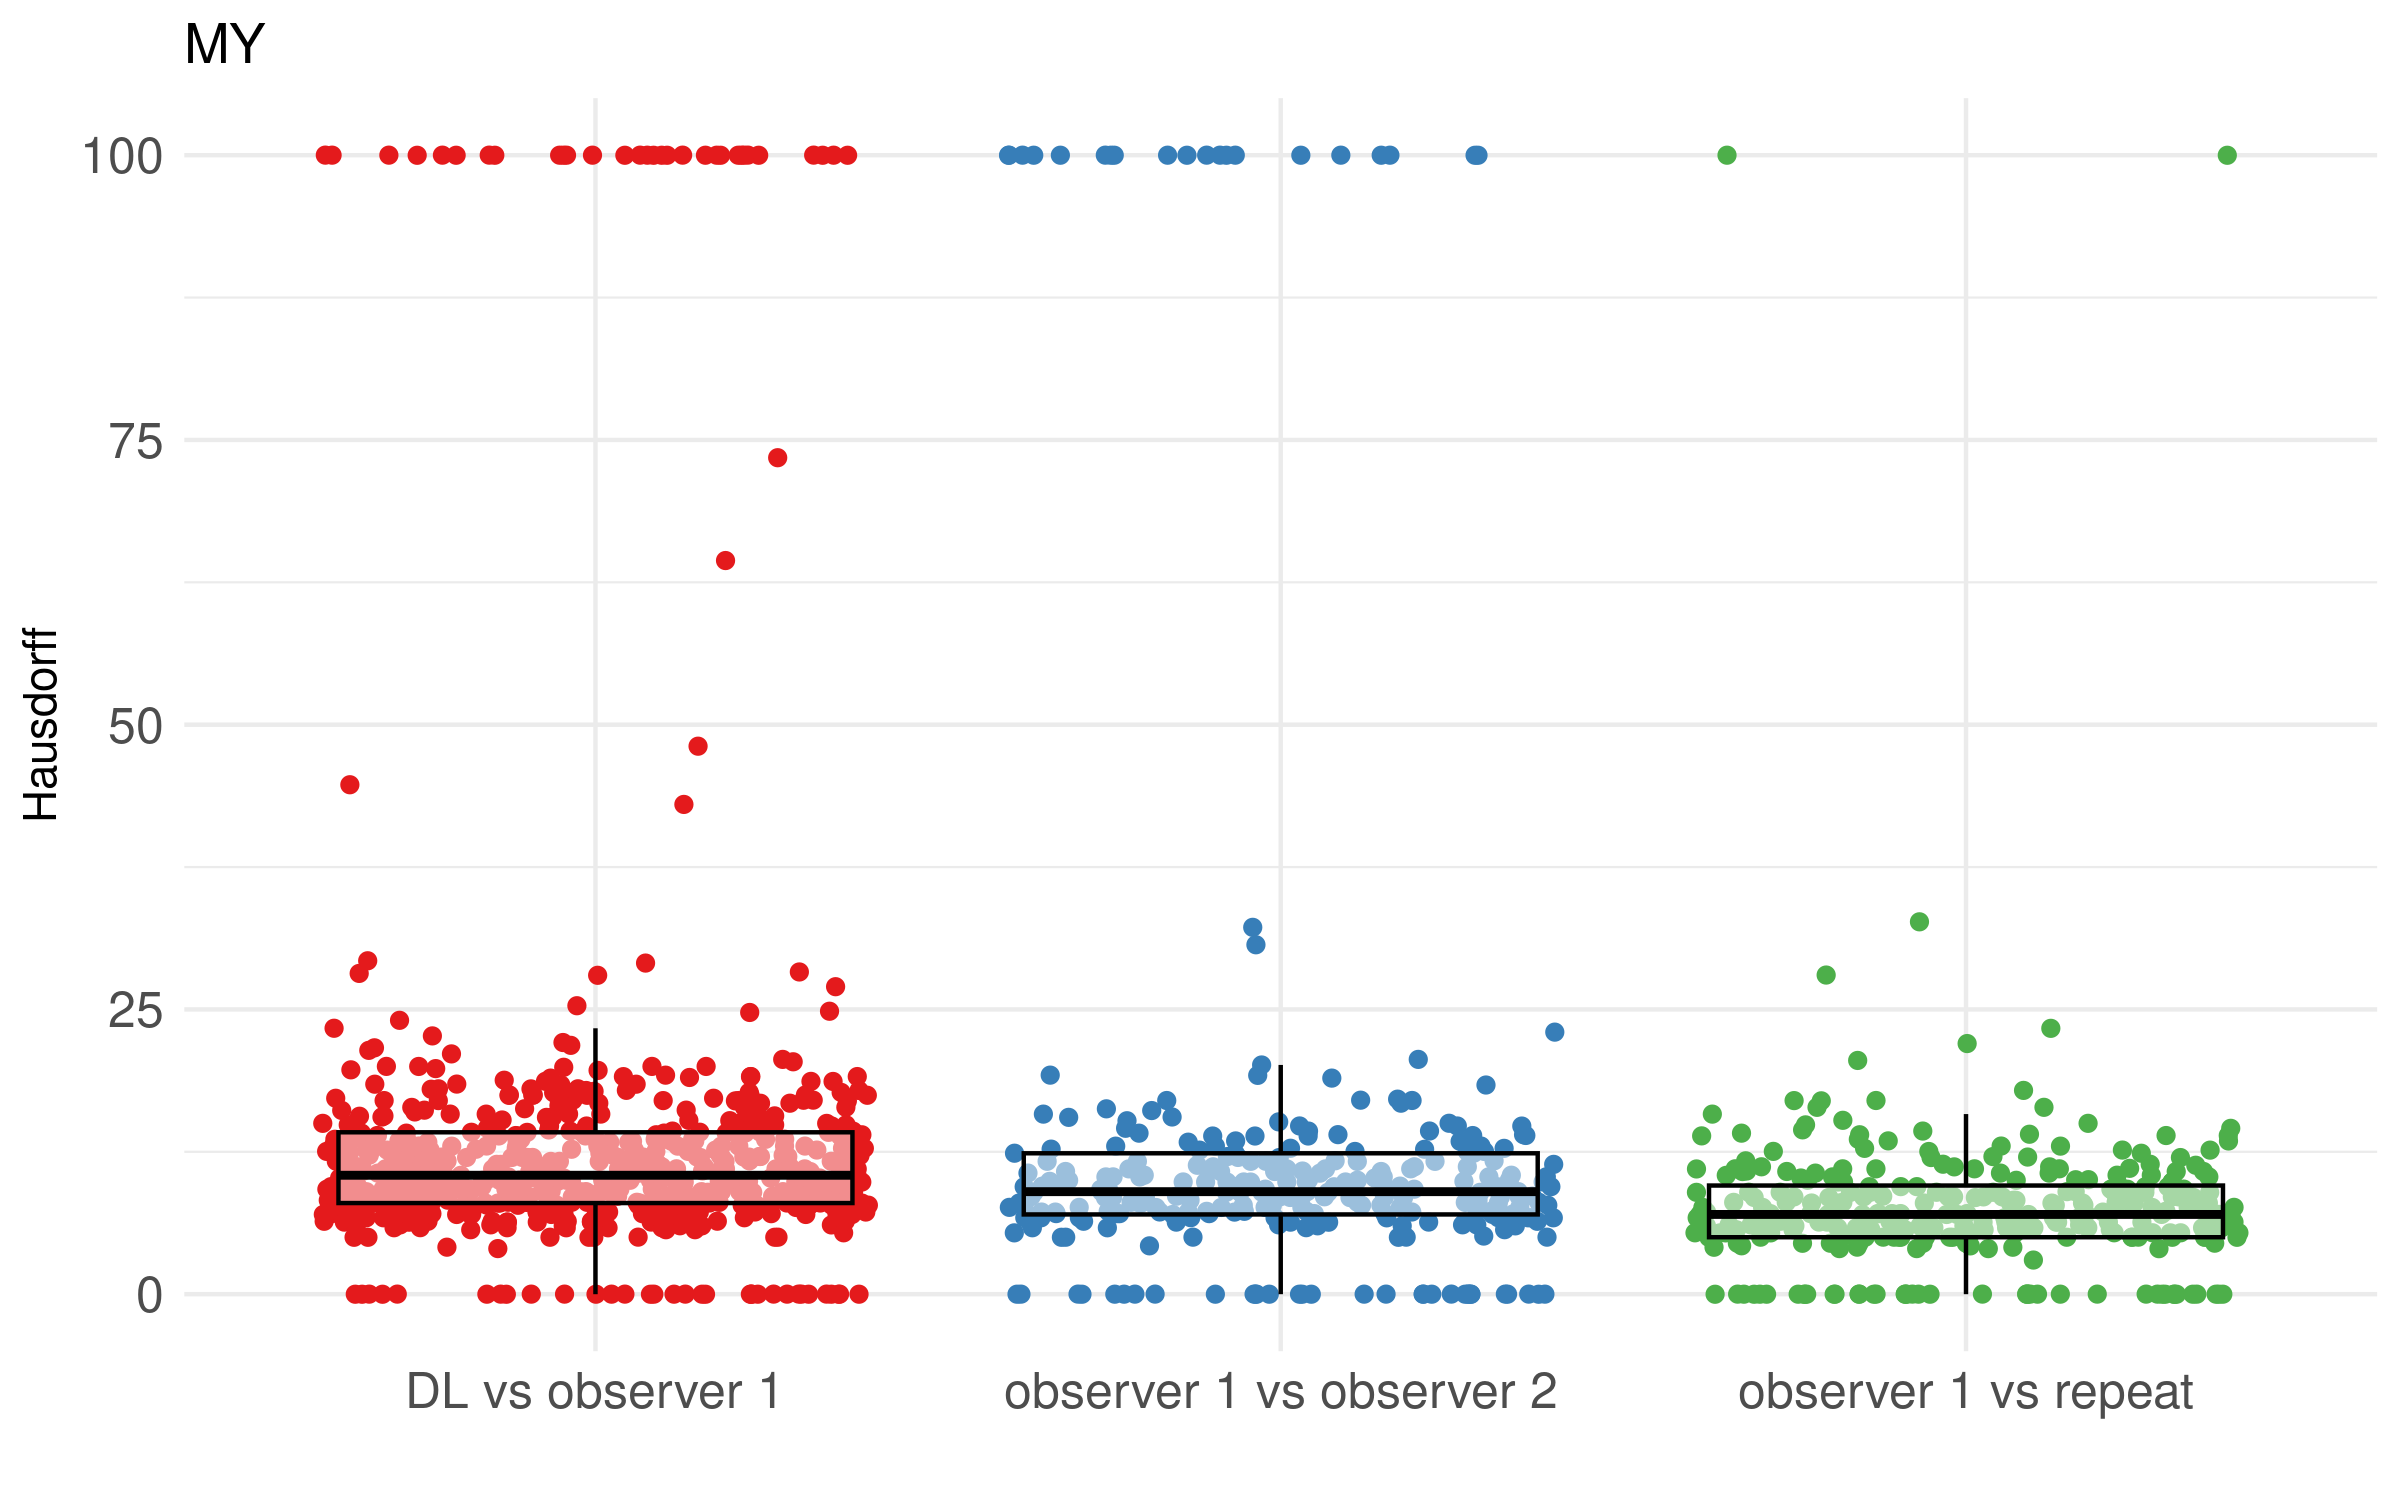

In [52]:
haus_data %>%
    mutate(comparison = str_c(methodA,methodB,sep=" vs "), Hausdorff=my) %>%
    mutate(Hausdorff = if_else(Hausdorff<100,Hausdorff,100)) %>% # add inf values to the plot
    filter(set == "test") %>%
    ggplot(aes(x=comparison,y=Hausdorff, color=comparison)) + geom_jitter() + ggtitle("MY") + geom_boxplot(color="black",alpha=.5,outlier.shape=NA) + scale_color_brewer(palette="Set1") +
    theme(legend.position = "none", axis.text = element_text(size = 12)) + xlab("")

### Log scale

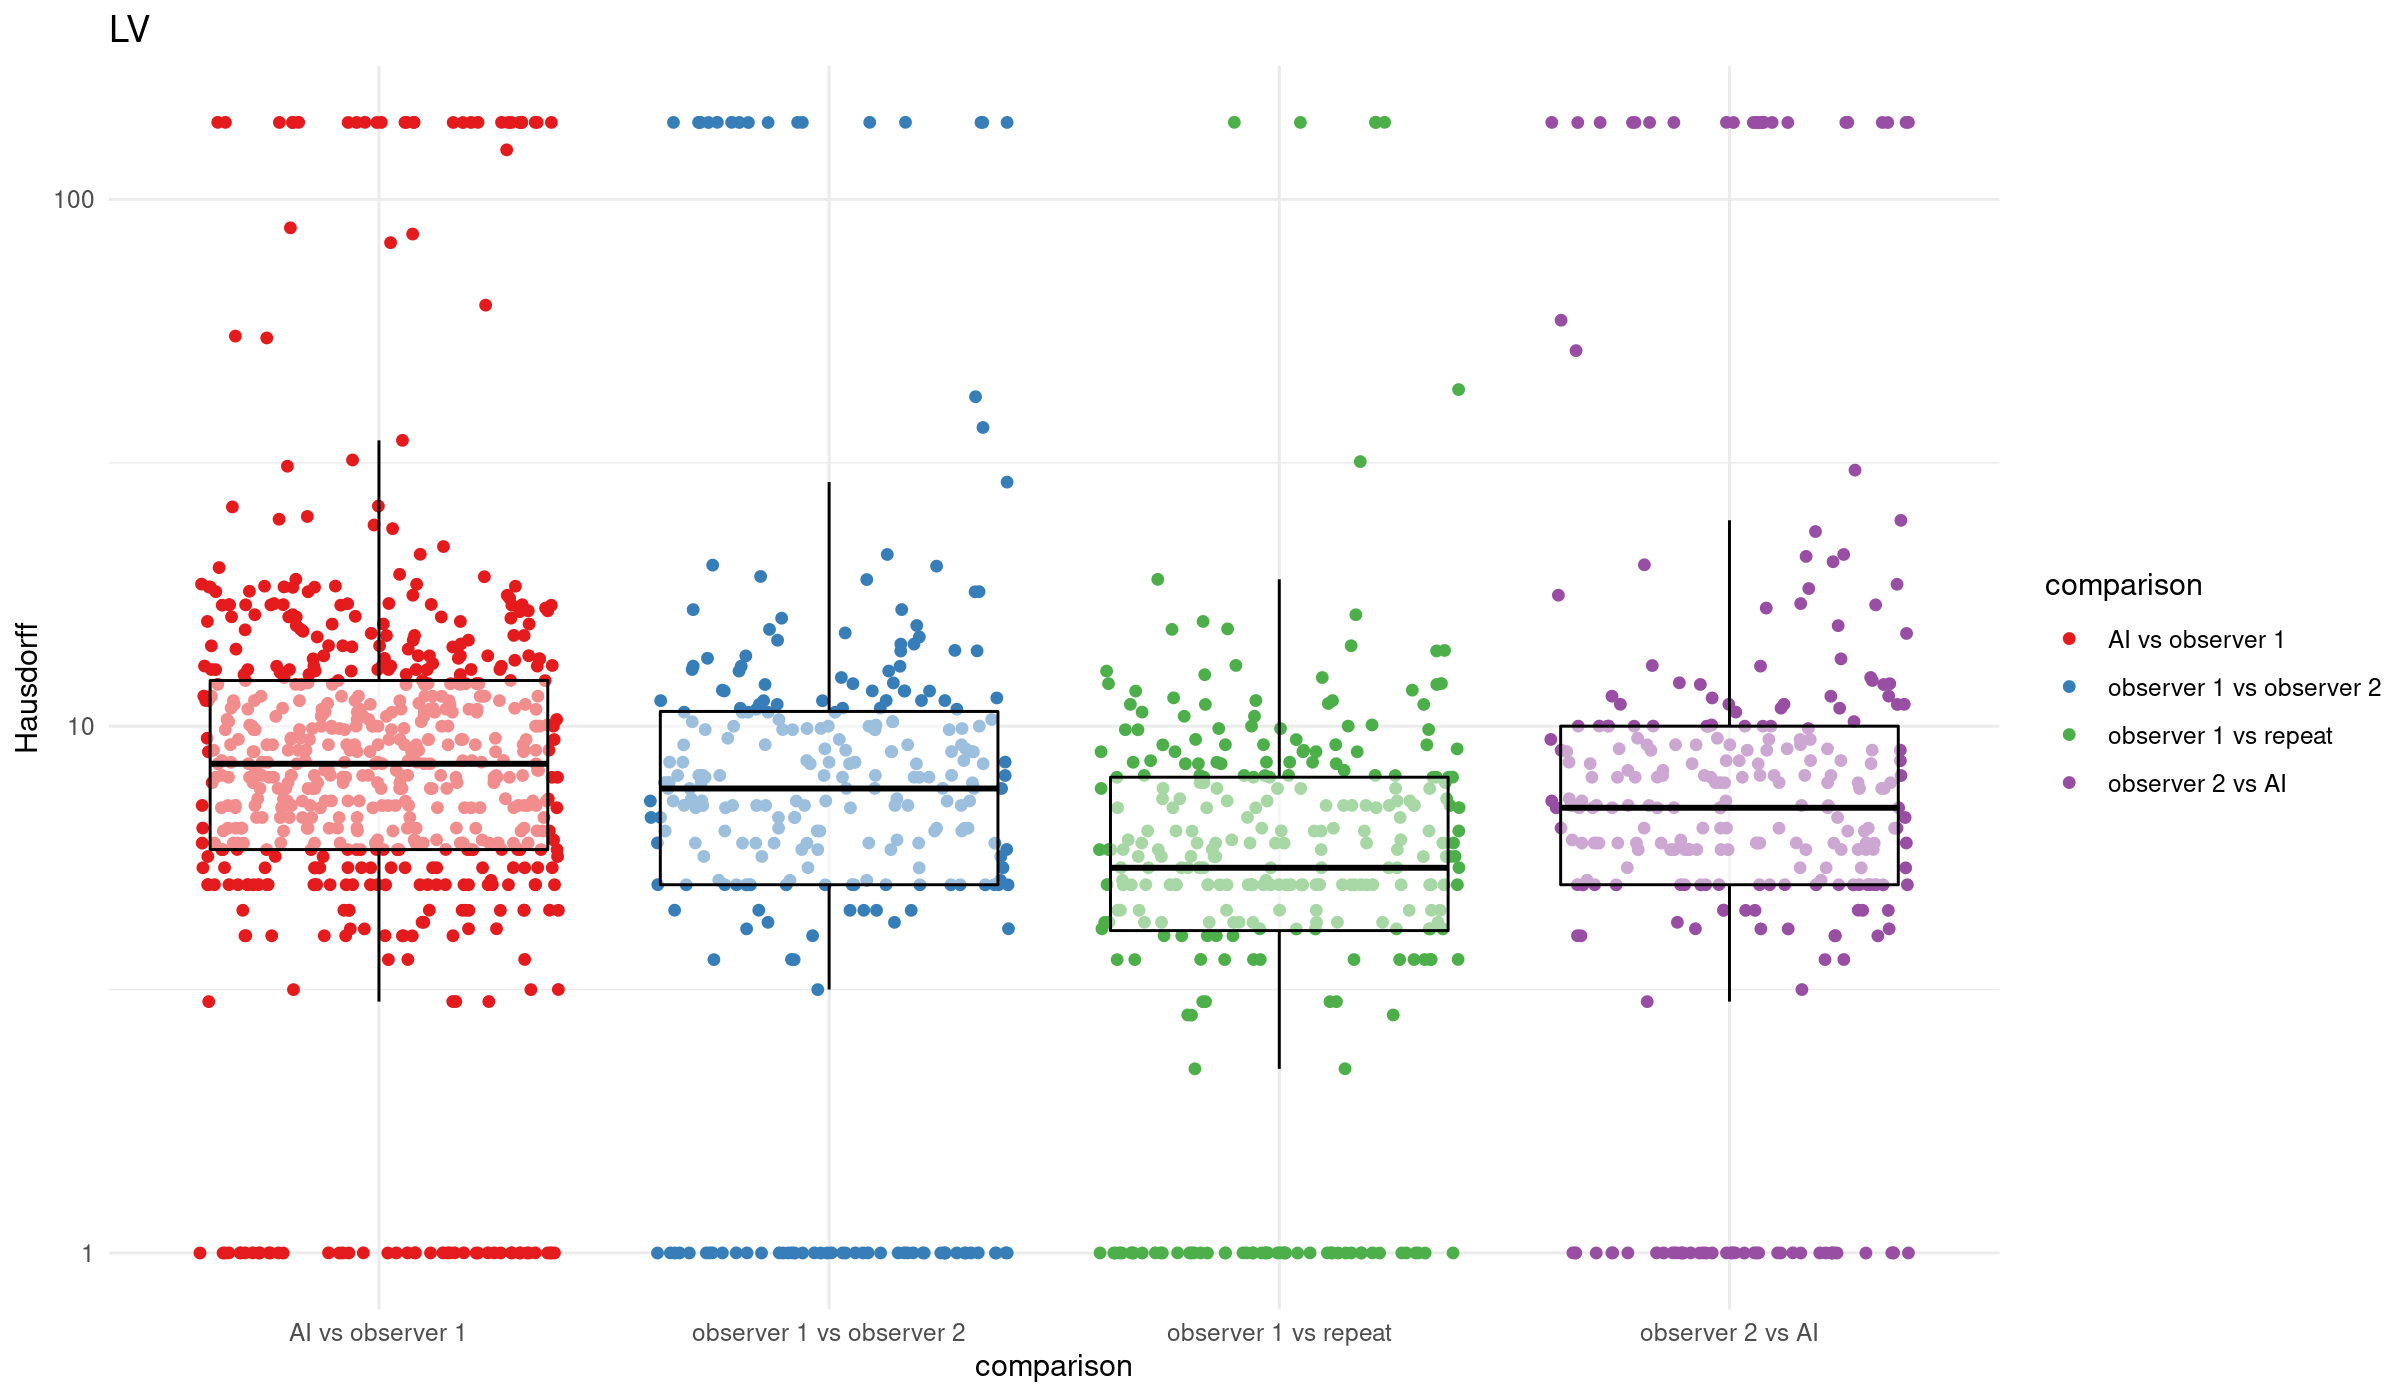

In [68]:
haus_data %>%
    mutate(comparison = str_c(methodA,methodB,sep=" vs "), Hausdorff=lv) %>%
    mutate(Hausdorff = if_else(lv<140,lv,140)) %>% # add inf values to the plot
    mutate(Hausdorff = if_else(Hausdorff>1,Hausdorff,1)) %>% # avoid log of 0
    filter(set == "test") %>%
    ggplot(aes(x=comparison,y=Hausdorff, color=comparison)) + geom_jitter() + ggtitle("LV") + geom_boxplot(color="black",alpha=.5,outlier.shape = NA) + scale_color_brewer(palette="Set1") +
    scale_y_log10() +
    NULL

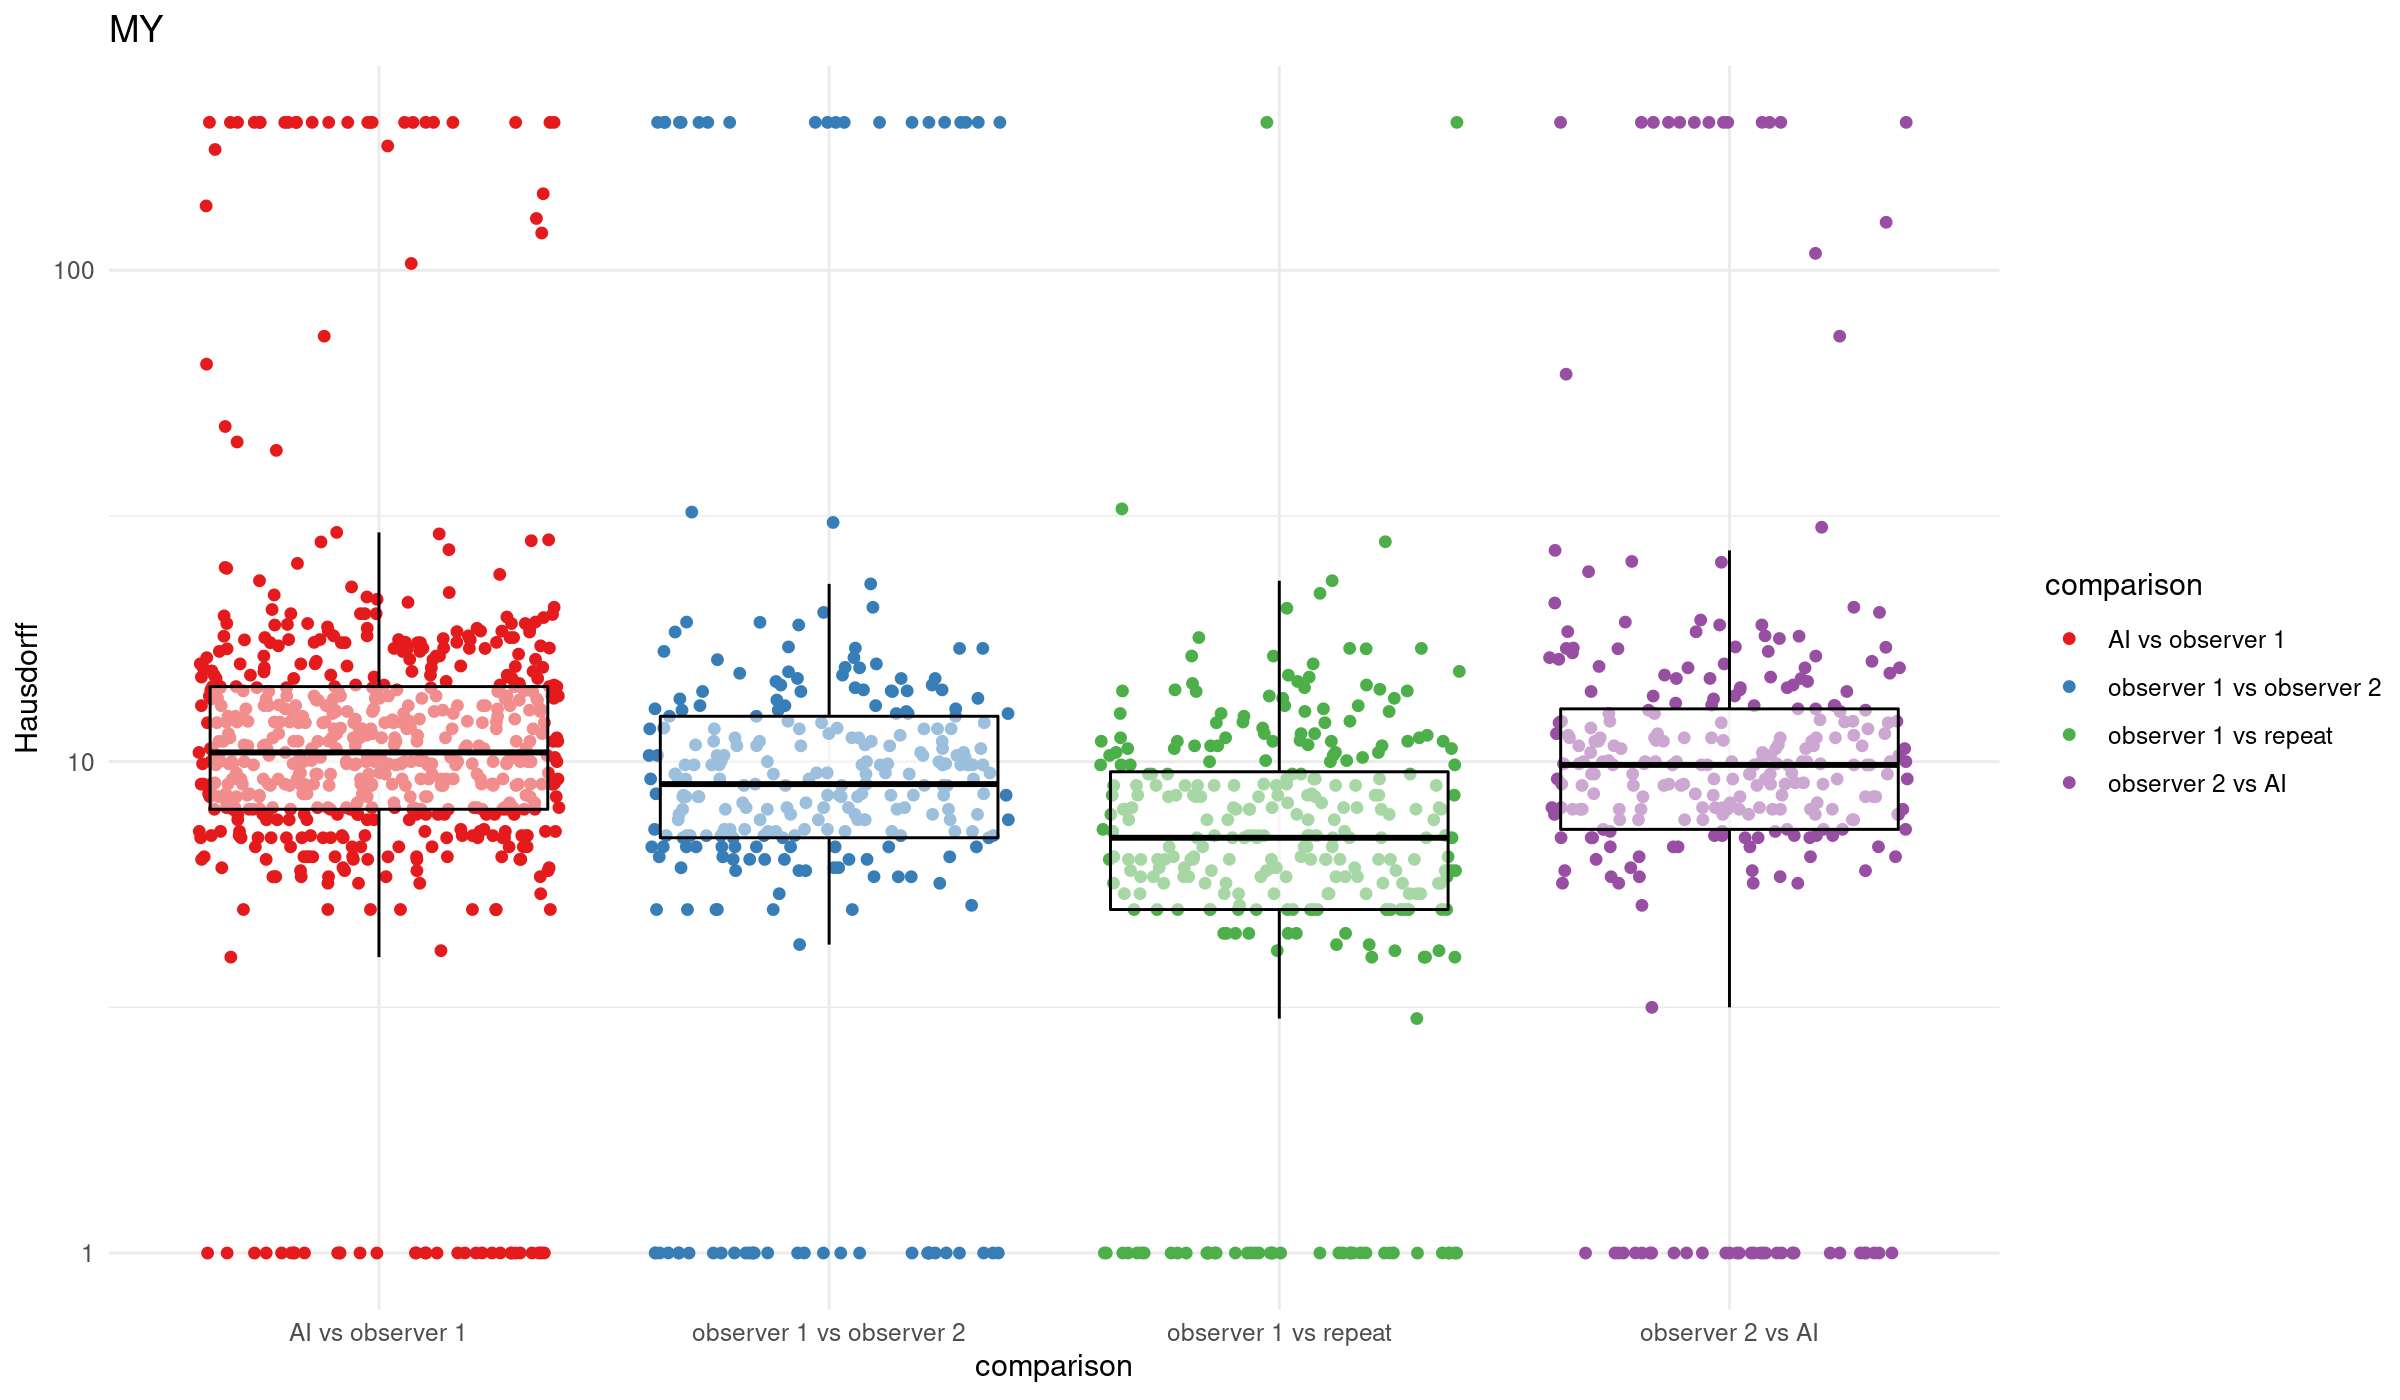

In [64]:
haus_data %>%
    mutate(comparison = str_c(methodA,methodB,sep=" vs "), Hausdorff=my) %>%
    mutate(Hausdorff = if_else(Hausdorff<200,Hausdorff,200)) %>% # add inf values to the plot
    mutate(Hausdorff = if_else(Hausdorff>1,Hausdorff,1)) %>% # avoid log of 0
    filter(set == "test") %>%
    ggplot(aes(x=comparison,y=Hausdorff, color=comparison)) + geom_jitter() + ggtitle("MY") + geom_boxplot(color="black",alpha=.5,outlier.shape = NA) + scale_color_brewer(palette="Set1") +
    scale_y_log10() +
    NULL

In [40]:
haus_data %>%
    filter(set=="test") %>%
    group_by(methodA, methodB) %>%
    summarize(across(c(lv,my),list(median=median,mad=mad)))

`summarise()` has grouped output by 'methodA'. You can override using the `.groups` argument.


methodA,methodB,lv_median,lv_mad,my_median,my_mad
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AI,observer 1,8.485281,4.323963,10.440307,4.412368
observer 1,observer 2,7.615773,3.878145,9.000000,3.705484
observer 1,repeat,5.385165,2.707135,7.000000,2.965200
observer 2,AI,7.000000,3.449659,9.848858,3.910736
